<a href="https://colab.research.google.com/github/vikram0050/Real-Time-Facial-Expression-recognition/blob/main/Vikramaditya_Sah_Real_Time_Facial_Expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training A Face Emotion Detector

# Project Introduction
The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms.

One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention.

Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance.

While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms.

Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**


Importing the required python libraries like numpy,pandas,tensorflow,sklearn me

In [ ]:
# importing libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers,applications
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D 

In [ ]:
train_dir= r"/content/drive/MyDrive/Real-Time-Facial-Expression-recognition/train"

In [ ]:
val_dir="/content/drive/MyDrive/Real-Time-Facial-Expression-recognition/validation"

In [ ]:
test_dir="/content/drive/MyDrive/Real-Time-Facial-Expression-recognition/test"

# EDA

First we'll do an image count for validation and train dataset.

In [ ]:
# lsit of all emotions
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
#coounting all the emotions in train and validation set
def count_exp(path, set_):
    dict_ = {}
    for expression in emotions:
        dir_ = os.path.join(path, expression)
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(val_dir, 'test')

In [ ]:
#count for train data set
train_count

,angry,disgust,fear,happy,neutral,sad,surprise
train,3993,436,4103,5797,4982,4938,3205


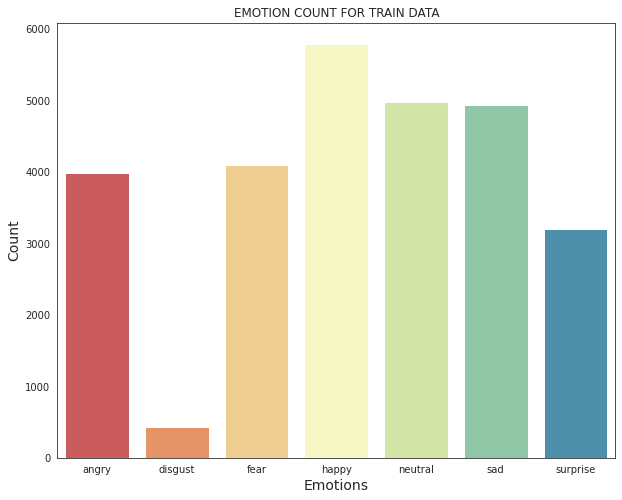

In [ ]:
#plotting emotion count for train data
sns.set_style("white")
plt.figure(figsize= (10,8))
sns.barplot(data=train_count, palette = 'Spectral')
plt.xlabel("Emotions", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("EMOTION COUNT FOR TRAIN DATA")
plt.show()

In [ ]:
#count for validation data set
test_count

,angry,disgust,fear,happy,neutral,sad,surprise
test,960,111,1018,1825,1216,1139,797


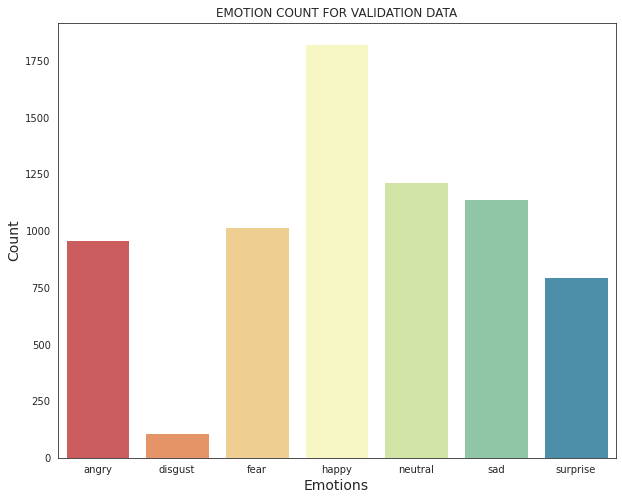

In [ ]:
#plotting emotion count for validation data
plt.figure(figsize= (10,8))
sns.barplot(data=test_count, palette = 'Spectral')
plt.xlabel("Emotions", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("EMOTION COUNT FOR VALIDATION DATA")
plt.show()

Let's take a look at some of the images for each emotion nad check if the labels are correct.

In [ ]:
#function to plot images for all emotions

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

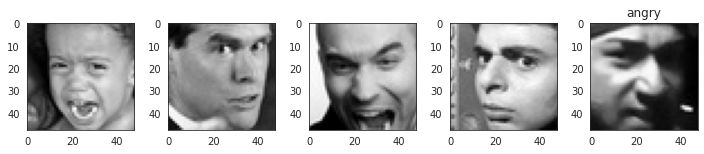

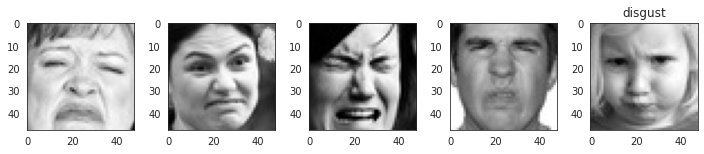

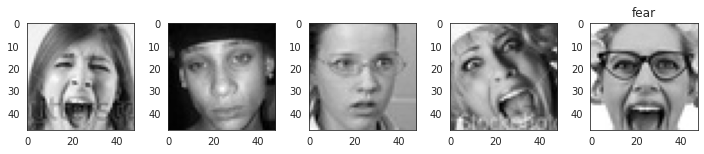

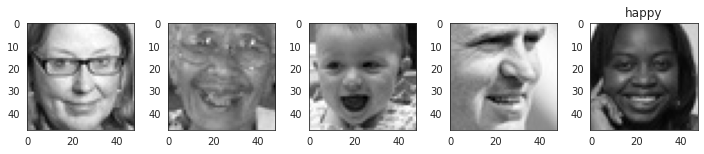

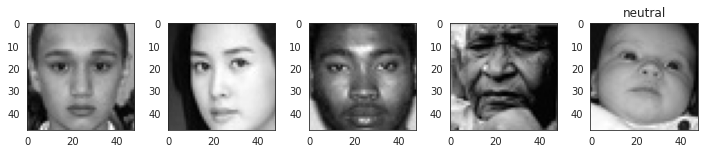

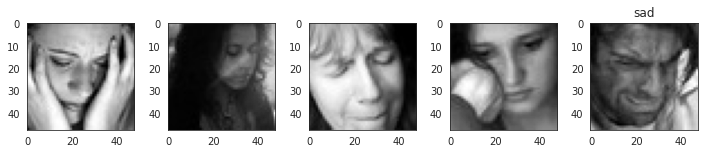

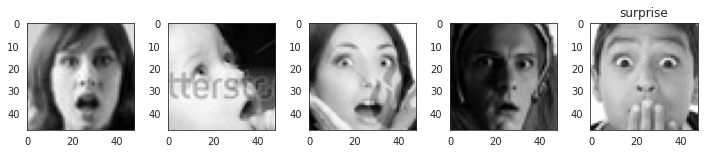

In [ ]:
#plotting images for each class
for emotion in emotions: 
    plot_images(os.path.join(train_dir, emotion))
    plt.title(emotion)

# DATA PROCESSING
**DATA AUGMENTATION**

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can apply any random transformations on each training image as it is passed to the model. This will not only make your model robust but will also save up on the overhead memory. ImageDataGenerator class ensures that the model receives new variations of the images at each epoch.

In [ ]:
#Defining the augmentation parameters

'''
rotation_range:      rotates the image with the amount of degrees we provide
width_shift_range:   shifts the image randomly to the right or left along the width of the image
height_shift range:  shifts image randomly to up or down along the height of the image
horizontal_flip:     flips the image horizontally
rescale:             to scale down the pixel values in our image between 0 and 1
zoom_range:          applies random zoom to our image
brightness_range:    randomly changes the brightness of the image
'''


train_set = ImageDataGenerator(          rotation_range = 20,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         zoom_range = 0.1,
                                         brightness_range=[0.7,1.3] )

val_set = ImageDataGenerator( rescale = 1./255 )

test_set = ImageDataGenerator( rescale = 1./255 )

In [ ]:
#applying augmentation on our datasets
''' 
target_size:   Size of the input image.
color_mode:    Set to rgb for 3 images with 3 channels and grayscale 1 channel.
batch_size:    Size of each batch in which data will be passed.
class_mode:    Set to binary for only two label classification and categorical for multilabel classification
'''

train_data = train_set.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 32,
                                                    color_mode ='grayscale',
                                                    class_mode = "categorical"
                                                   )
val_data = test_set.flow_from_directory( directory = val_dir,
                                                              target_size = (48,48),
                                                              batch_size = 32,
                                                               color_mode ='grayscale',
                                                              class_mode = "categorical"
                                                             )

test_data = test_set.flow_from_directory( directory = test_dir,
                                                              target_size = (48,48),
                                                              batch_size = 1,
                                                               color_mode ='grayscale',
                                                              class_mode = "categorical"
                                                             )

Found 27454 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# MODEL DEFINITION

We will build a sequential model of 4 convolutional layers and 2 fully connected layers with the activation function "Relu". Our output layer will have the function "softmax" for final predicton.

In [ ]:
#CNN model definintion

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(5,5),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.35))
#dropout randomly switches off some neurons in the network which forces the data to find new paths,Therefore, this reduces overfitting.

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.35))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.35))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())

#1st Fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))


#2nd  Fully connected layer layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

#Final prediction layer
model.add(Dense(7, activation='softmax'))


#MODEL COMPILATION
opt = Adam(learning_rate = 0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:

# defining a callback that will save the best model
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# no. of epoch
epochs = 40

#MODEL TRAINING

In [ ]:
# Fitting and training the model
history = model.fit(train_data,
                        epochs=epochs,
                        validation_data = val_data,
                        callbacks=callbacks_list
                        ) 

Epoch 1/40
858/858 [==============================] - ETA: 0s - loss: 2.0100 - accuracy: 0.2033
Epoch 1: val_accuracy improved from -inf to 0.29748, saving model to model.h5
858/858 [==============================] - 6979s 8s/step - loss: 2.0100 - accuracy: 0.2033 - val_loss: 1.7395 - val_accuracy: 0.2975
Epoch 2/40
858/858 [==============================] - ETA: 0s - loss: 1.8023 - accuracy: 0.2676
Epoch 2: val_accuracy improved from 0.29748 to 0.33513, saving model to model.h5
858/858 [==============================] - 1375s 2s/step - loss: 1.8023 - accuracy: 0.2676 - val_loss: 1.7001 - val_accuracy: 0.3351
Epoch 3/40
858/858 [==============================] - ETA: 0s - loss: 1.6657 - accuracy: 0.3351
Epoch 3: val_accuracy improved from 0.33513 to 0.37928, saving model to model.h5
858/858 [==============================] - 1373s 2s/step - loss: 1.6657 - accuracy: 0.3351 - val_loss: 1.5742 - val_accuracy: 0.3793
Epoch 4/40
858/858 [==============================] - ETA: 0s - loss: 1.5